# EndSARS Twitter Analysis

Sentiment and Network Analysis of the #EndSARS protest movement that occured in 2020 in Nigeria. 

## SetUp

### Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
import requests
import os
import json
import re
import ast
import csv
import gensim
from searchtweets import ResultStream, gen_request_parameters, load_credentials, collect_results
# import fastText as ft
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime, timedelta, date
import networkx as nx


%matplotlib inline
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

### Connecting to Twitter

I suggest you use Twitter's official searchtweets api which is easy to use and reliable.
<br>In order to get past the tweets retrieval limit, you might also need to  use the premium search api.

- Create a hidden yaml file (.yaml) which contains details about your twitter api keys
- Create a variable that stores the twitter api credentials from the hiddem yaml file above.

**Keywords**: EndSARS, Soro Soke, Police Brutality, lekki toll gate, anti-robbery, lekki massacre, End bad governance,
End swat, buhari is a bad boy, sanwa-olu is a murderer, #LekkiMassacre

Helpful links:
- https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-recent
- https://github.com/twitterdev/search-tweets-python/tree/v2#using-the-twitter-search-apis-python-wrapper

In [2]:
bode_all_search_args = load_credentials(".twitter_keys.yaml",
                                        yaml_key="search_tweets_all_bode_v2",
                                        env_overwrite=False)

In [3]:
def retrieve_tweets(start_date, 
                    end_date,
                    max_tweets=30000,
                    results_per_call=100,
                    search_args=bode_all_search_args,
                    keywords_query="""#EndSARS OR "Soro Soke" OR "lekki toll gate" OR "anti-robbery squad" OR
"lekki massacre" OR "End bad governance" OR "End swat" OR #LekkiMassacre lang:en""",
                    tweet_resp_fields="id,author_id,created_at,text,geo,referenced_tweets,in_reply_to_user_id,\
                    entities,public_metrics", 
                    expansions_resp_fields="author_id,entities.mentions.username,geo.place_id,in_reply_to_user_id,\
referenced_tweets.id,referenced_tweets.id.author_id", 
                    user_resp_fields="id,created_at,location,username,verified,public_metrics",
                    place_resp_fields="country,country_code,full_name,geo,id,name,place_type"):
    """
    Create a function that gets tweets using the premium search API where matching a certain keyword during a
    certain date range and returns all these tweets as a list
    """
    tweets_query = gen_request_parameters(query=keywords_query, 
                                          start_time=start_date, 
                                          end_time=end_date,
                                          expansions=expansions_resp_fields,
                                          tweet_fields=tweet_resp_fields,
                                          user_fields=user_resp_fields,
                                          place_fields=place_resp_fields,
                                          results_per_call=results_per_call)
    tweets = collect_results(tweets_query,
                             max_tweets=max_tweets,
                             result_stream_args=search_args)
    return tweets

In [4]:
def get_dt_after(start_date, delta=timedelta(days=7)):
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = start_dt + delta
    return end_dt.strftime("%Y-%m-%d")

In [5]:
def create_tweets_df(dates_list, 
                     max_tweets=30000,
                     results_per_call=100,
                     search_args=bode_all_search_args,
                     keywords_query="""#EndSARS OR "Soro Soke" OR "lekki toll gate" OR "anti-robbery squad" OR
"lekki massacre" OR "End bad governance" OR "End swat" OR #LekkiMassacre lang:en""",
                     tweet_resp_fields="""id,author_id,created_at,text,geo,referenced_tweets,in_reply_to_user_id,entities,public_metrics""",
                     expansions_resp_fields="""author_id,entities.mentions.username,geo.place_id,in_reply_to_user_id,referenced_tweets.id,referenced_tweets.id.author_id""", 
                     user_resp_fields="id,created_at,location,username,verified,public_metrics",
                     place_resp_fields="country,country_code,full_name,geo,id,name,place_type"):
    """
    Create a function that Creates a dataframe from the tweets you've retrieved using the retieve_tweets function 
    you created above. This functions should also take a list of datest you want to get tweets from
    """
    tweets = []
    for date in dates_list:
        tweets += retrieve_tweets(start_date=date, end_date=get_dt_after(start_date=date),
                                  max_tweets=max_tweets, results_per_call=results_per_call, 
                                  search_args=search_args, keywords_query=keywords_query, 
                                  tweet_resp_fields=tweet_resp_fields, user_resp_fields=user_resp_fields, 
                                  place_resp_fields=place_resp_fields, expansions_resp_fields=expansions_resp_fields
                                 )
    df = pd.DataFrame(tweets)
    df.to_pickle(f"./data/endsars_tweets_{dates_list[0].replace('-', '')}_{dates_list[-1].replace('-', '')}.pkl")
    return df

In [6]:
my_search_args = load_credentials(".twitter_keys.yaml",
                                  yaml_key="search_tweets_recent_v2",
                                  env_overwrite=False)

In [18]:
def create_url(user_ids, user_fields="user.fields=username,name,created_at,location,verified,public_metrics"):
    url = "https://api.twitter.com/2/users?ids={}&{}".format(user_ids, user_fields)
    return url


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def connect_to_endpoint(url, headers):
    response = requests.request("GET", url, headers=headers)
#     print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()['data']

def get_user_details(user_id_list):
    """
    user_id_list: list of lists which contains user ids, each list should have a maximum of 100 ids
    """
    users = []
    headers = create_headers(my_search_args['bearer_token'])
    for user_list in user_id_list:
        user_ids = ",".join(user_list)
        url = create_url(user_ids=user_ids)
        users += connect_to_endpoint(url=url, headers=headers)
    users_df = pd.DataFrame(users)
    users_df.to_pickle(f"./data/endsars_tweets_user_details.pkl")
    return users_df

## Fetch and Clean Data

Use the functions you've created above to collect all the tweets

### Get Tweets

In [22]:
def days_cur_month(m=1, y=2021):
    if m == 12:
        ndays = (date(y+1, 1, 1) - date(y, m, 1)).days
    else:
        ndays = (date(y, m+1, 1) - date(y, m, 1)).days
    d1 = date(y, m, 1)
    d2 = date(y, m, ndays)
    delta = d2 - d1
    return [(d1 + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(0, delta.days+1, 7)]

In [23]:
# dates = []
# for dt in range(2, 8):
#     dates += days_cur_month(m=dt, y=2020)
# dates += days_cur_month(12, 2020)
# dates += days_cur_month()

In [35]:
# tweets_df = create_tweets_df(dates_list=dates, max_tweets=5000)
# tweets_df.shape

In [8]:
# tweets_1020 = pd.read_pickle("./data/endsars_tweets_20201001_20201029.pkl")
# tweets_1020.shape

In [9]:
# tweets_0120_0221 = pd.read_pickle("./data/endsars_tweets_20200101_20210222.pkl")
# tweets_0120_0221.shape

In [10]:
# tweets_0220_0121 = pd.read_pickle("./data/endsars_tweets_20200201_20210129.pkl")
# tweets_0220_0121.shape

In [11]:
# tweets_011220_081220 = pd.read_pickle("./data/endsars_tweets_20201201_20201208.pkl")
# tweets_011220_081220.shape

In [12]:
# tweets_201020 = pd.read_pickle("./data/endsars_tweets_20201019_20201020.pkl")
# tweets_201020.shape

In [13]:
# tweets_df = pd.concat([tweets_0220_0121, tweets_0120_0221, tweets_1020, tweets_201020, tweets_011220_081220])
# tweets_df.shape

In [14]:
# tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

In [15]:
# tweets_df.info()

In [16]:
# tweets_df.to_pickle("./data/endsars_tweets_master_db.pkl")

In [17]:
# tweets_df = pd.read_pickle("./data/endsars_tweets_master_db.pkl")
# tweets_df.shape

Make sure to save the tweets after this process, use a file format that won't comprimise the characters in tweets

### Get User details

In [1]:
# author_ids = list(tweets_df[~tweets_df.author_id.isnull()].author_id.unique())
# len(author_ids)

In [2]:
# c = 0
# list_of_auth_ids = []
# temp_list = []
# for auth_id in author_ids:
#     temp_list.append(auth_id)
#     if len(temp_list) == 99:
#         list_of_auth_ids.append(temp_list)
#         temp_list = []
# list_of_auth_ids.append(temp_list)

In [222]:
get_user_details([['406533892','2848603625','949215757988171776']])

,verified,created_at,public_metrics,name,location,username,id
0,False,2011-11-06T20:55:51.000Z,"{'followers_count': 1287, 'following_count': 1...",Alexander,"Lagos, Nigeria",xanderwayne,406533892
1,False,2014-10-28T18:33:01.000Z,"{'followers_count': 224, 'following_count': 10...",Carrot Top,"Lagos, Nigeria",carrotop_ds,2848603625
2,False,2018-01-05T09:47:27.000Z,"{'followers_count': 384, 'following_count': 13...",kenny,"Lagos, Nigeria",proudtwinnie,949215757988171776


In [22]:
users_df = pd.read_pickle("./data/endsars_tweets_user_details.pkl")
users_df.shape

(112380, 7)

In [23]:
cols_rename = {'id': 'author_id'}
cols_rename.update({col: f"user_{col}" for col in ['public_metrics', 'location', 'created_at', 'name', 'verified']})
cols_rename

{'id': 'author_id',
 'public_metrics': 'user_public_metrics',
 'location': 'user_location',
 'created_at': 'user_created_at',
 'name': 'user_name',
 'verified': 'user_verified'}

In [24]:
users_df.rename(columns=cols_rename, inplace=True)

In [25]:
users_df.head()

,user_public_metrics,author_id,user_location,user_created_at,user_name,username,user_verified
0,"{'followers_count': 1288, 'following_count': 1...",406533892,"Lagos, Nigeria",2011-11-06T20:55:51.000Z,Alexander,xanderwayne,False
1,"{'followers_count': 224, 'following_count': 10...",2848603625,"Lagos, Nigeria",2014-10-28T18:33:01.000Z,Carrot Top,carrotop_ds,False
2,"{'followers_count': 384, 'following_count': 13...",949215757988171776,"Lagos, Nigeria",2018-01-05T09:47:27.000Z,kenny,proudtwinnie,False
3,"{'followers_count': 647, 'following_count': 13...",3062901987,"Ilorin, Nigeria",2015-02-25T18:46:16.000Z,A.A: ELDORADO,Eldorado4eva,False
4,"{'followers_count': 1173, 'following_count': 9...",1081991545497284608,NaN,2019-01-06T19:11:01.000Z,Florence Ade Bimpe👑,Flobim1,False


### Join Dataframes

In [26]:
tweets_df = tweets_df.merge(users_df, on='author_id', how='left')
tweets_df.shape

(288358, 23)

In [27]:
tweets_df.head()

,id,author_id,text,created_at,entities,public_metrics,referenced_tweets,in_reply_to_user_id,geo,users,tweets,places,newest_id,oldest_id,result_count,next_token,withheld,user_public_metrics,user_location,user_created_at,user_name,username,user_verified
0,1225932212933144581,406533892,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:50+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 1288, 'following_count': 1...","Lagos, Nigeria",2011-11-06T20:55:51.000Z,Alexander,xanderwayne,False
1,1225932207711281152,2848603625,Even God love dreads that was why he gave sams...,2020-02-07 23:59:49+00:00,"{'hashtags': [{'start': 112, 'end': 120, 'tag'...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 224, 'following_count': 10...","Lagos, Nigeria",2014-10-28T18:33:01.000Z,Carrot Top,carrotop_ds,False
2,1225932128002678792,949215757988171776,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:30+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 384, 'following_count': 13...","Lagos, Nigeria",2018-01-05T09:47:27.000Z,kenny,proudtwinnie,False
3,1225932101926707200,3062901987,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:24+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 647, 'following_count': 13...","Ilorin, Nigeria",2015-02-25T18:46:16.000Z,A.A: ELDORADO,Eldorado4eva,False
4,1225932076735700992,1081991545497284608,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:18+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 1173, 'following_count': 9...",NaN,2019-01-06T19:11:01.000Z,Florence Ade Bimpe👑,Flobim1,False


In [29]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288358 entries, 0 to 288357
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   282330 non-null  object             
 1   author_id            282330 non-null  object             
 2   text                 282330 non-null  object             
 3   created_at           282330 non-null  datetime64[ns, UTC]
 4   entities             280690 non-null  object             
 5   public_metrics       282330 non-null  object             
 6   referenced_tweets    266609 non-null  object             
 7   in_reply_to_user_id  11115 non-null   object             
 8   geo                  1001 non-null    object             
 9   users                3014 non-null    object             
 10  tweets               3014 non-null    object             
 11  places               751 non-null     object             
 12  ne

In [55]:
tweets_df.to_pickle("./data/endsars_tweets_master_db.pkl")

In [1]:
tweets_df = pd.read_pickle("./data/endsars_tweets_master_db.pkl")
tweets_df.shape

NameError: name 'pd' is not defined

In [57]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

In [58]:
tweets_df.groupby([pd.Grouper(key='created_at', freq='W')]).size()

created_at
2020-01-05 00:00:00+00:00      914
2020-01-12 00:00:00+00:00     4596
2020-01-19 00:00:00+00:00     2267
2020-01-26 00:00:00+00:00     2351
2020-02-02 00:00:00+00:00      517
2020-02-09 00:00:00+00:00     6722
2020-02-16 00:00:00+00:00      797
2020-02-23 00:00:00+00:00     5000
2020-03-01 00:00:00+00:00     6796
2020-03-08 00:00:00+00:00     6631
2020-03-15 00:00:00+00:00     1030
2020-03-22 00:00:00+00:00      680
2020-03-29 00:00:00+00:00      407
2020-04-05 00:00:00+00:00     2147
2020-04-12 00:00:00+00:00     3613
2020-04-19 00:00:00+00:00     2493
2020-04-26 00:00:00+00:00     1635
2020-05-03 00:00:00+00:00      434
2020-05-10 00:00:00+00:00      463
2020-05-17 00:00:00+00:00     4614
2020-05-24 00:00:00+00:00      722
2020-05-31 00:00:00+00:00     2070
2020-06-07 00:00:00+00:00     2803
2020-06-14 00:00:00+00:00      769
2020-06-21 00:00:00+00:00     2473
2020-06-28 00:00:00+00:00     5000
2020-07-05 00:00:00+00:00     7225
2020-07-12 00:00:00+00:00     4502
2020-07-1

### Clean dataset

In [ ]:
def delete_duplicates(df, str_len=25):
    """
    Create a function that looks at the tweets in the tweets dataframe and other characters and delete 
    duplicates as sometimes we can get duplicate data/tweets. For example if I tweet something and someone else
    retweets it then this could possibly be a duplicate. Is this useful information? You need to decide of course.
    """

def preprocess_tweet(tweet):
    """
    Create a function that preprocess the text in a single tweet. Suggestions for this function are:
    - correct all multiple white spaces to a single white space
    - convert all urls to string "URL"
    - if the username isn't relevant then convert @username to "AT_USER"
    - converts emoji's to text description of the emoji
    """

In [ ]:
tweets_df = delete_duplicates(tweets_to_analyse)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df['text_clean'] = tweets_df['text'].apply(preprocess_tweet)

In [2]:
tweets_df = pd.read_pickle("./data/endsars_tweets_master_clean_data.pkl")
tweets_df.shape

(418624, 37)

In [3]:
tweets_df.reset_index(drop=True, inplace=True)

In [4]:
tweets_df.head()

,id,author_id,text,created_at,entities,public_metrics,referenced_tweets,in_reply_to_user_id,geo,users,tweets,places,newest_id,oldest_id,result_count,next_token,withheld,user_public_metrics,user_location,user_created_at,user_name,username,user_verified,possibly_sensitive,context_annotations,reply_count,user_reply_count,like_count,user_like_count,quote_count,user_quote_count,retweet_count,user_retweet_count,hashtags,state,country,mentions
0,1225932212933144581,406533892,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:50+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 1288, 'following_count': 1...","Lagos, Nigeria",2011-11-06T20:55:51.000Z,Alexander,xanderwayne,False,NaN,NaN,0.0,None,0.0,None,0.0,None,2097.0,None,[],None,None,[bbcnewspidgin]
1,1225932207711281152,2848603625,Even God love dreads that was why he gave sams...,2020-02-07 23:59:49+00:00,"{'hashtags': [{'start': 112, 'end': 120, 'tag'...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 224, 'following_count': 10...","Lagos, Nigeria",2014-10-28T18:33:01.000Z,Carrot Top,carrotop_ds,False,NaN,NaN,0.0,None,0.0,None,0.0,None,0.0,None,[EndSARS],None,None,None
2,1225932128002678792,949215757988171776,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:30+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 384, 'following_count': 13...","Lagos, Nigeria",2018-01-05T09:47:27.000Z,kenny,proudtwinnie,False,NaN,NaN,0.0,None,0.0,None,0.0,None,2097.0,None,[],None,None,[bbcnewspidgin]
3,1225932101926707200,3062901987,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:24+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 647, 'following_count': 13...","Ilorin, Nigeria",2015-02-25T18:46:16.000Z,A.A: ELDORADO,Eldorado4eva,False,NaN,NaN,0.0,None,0.0,None,0.0,None,2097.0,None,[],None,None,[bbcnewspidgin]
4,1225932076735700992,1081991545497284608,"RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...",2020-02-07 23:59:18+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...","{'retweet_count': 2097, 'reply_count': 0, 'lik...","[{'type': 'retweeted', 'id': '1225671357100199...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'followers_count': 1173, 'following_count': 9...",NaN,2019-01-06T19:11:01.000Z,Florence Ade Bimpe👑,Flobim1,False,NaN,NaN,0.0,None,0.0,None,0.0,None,2097.0,None,[],None,None,[bbcnewspidgin]


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418624 entries, 0 to 418623
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   411234 non-null  object             
 1   author_id            411234 non-null  object             
 2   text                 411234 non-null  object             
 3   created_at           411234 non-null  datetime64[ns, UTC]
 4   entities             409126 non-null  object             
 5   public_metrics       411234 non-null  object             
 6   referenced_tweets    387530 non-null  object             
 7   in_reply_to_user_id  14026 non-null   object             
 8   geo                  1454 non-null    object             
 9   users                3695 non-null    object             
 10  tweets               3695 non-null    object             
 11  places               932 non-null     object             
 12  ne

## Alt data

In [ ]:
df = pd.read_excel('https://query.data.world/s/rghc6hq5b32ertwgebgwuyx2lcpxvt')

## Tweets Analysis

Now it's time to analyse this data to try and get some interesting insights. Below are some questions you can answer to get started but the best Data Scientists are creative thinkers so think out of th ebox to decide what will be interesting insight

**What locations in Nigeria and around the world were the hashtags popular?**

In [20]:
tweets_df.user_location.value_counts()[:10]

Lagos, Nigeria                    47252
Nigeria                           31038
Abuja, Nigeria                     8401
Lagos                              7858
Ibadan, Nigeria                    2943
Port Harcourt, Nigeria             2688
Earth                              2372
Africa                             2338
Federal Capital Territory, Nig     2147
Abuja                              1960
Name: user_location, dtype: int64

In [18]:
tweets_df.state.value_counts()[:10]

Lagos                        153
Ikeja                        128
Abuja                         68
Victoria Island               43
Port Harcourt                 37
Ibadan                        30
Enugu                         20
Ikorudu                       18
Federal Capital Territory     15
Benin-City                    11
Name: state, dtype: int64

In [19]:
tweets_df.country.value_counts()[:10]

Nigeria           771
United States      49
United Kingdom     22
Deutschland        14
Canada              9
Ghana               8
South Africa        6
Australia           3
Liberia             2
भारत                2
Name: country, dtype: int64

**How far did the hashtag reach and how deep was this reach?**

**When the did movement start on social media? When did it reach critical mass?**

In [ ]:
tw

**What were the most popular words or terms used during the movement?**

**Who were the key influences and proponents involved in the movement?**

**What was the most popular tweet?**

**What is the general sentiment of the tweets about the movement? How has this changed from the start of the movement till now?**

**Were there any bots or bad actors spreading fake news around the movement?**

**What are some examples of this fake news?**

## Network Analysis

In [25]:
G = nx.DiGraph()

G.add_nodes_from(['A', 'B', 'C', 'D'])
G.add_edge('A', 'B')
G.add_edge('B', 'C')
G.add_edge('D', 'B')
G.add_edge('C', 'B')
G.add_edge('C', 'E')

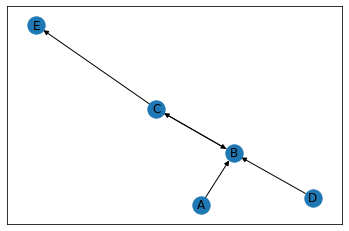

In [28]:
nx.draw_networkx(G)

In [24]:
nx.degree_centrality(G)

{'A': 0.3333333333333333,
 'B': 1.0,
 'C': 0.3333333333333333,
 'D': 0.3333333333333333}

In [11]:
tweets_df.iloc[0]

id                                                   1225932212933144581
author_id                                                      406533892
text                   RT @bbcnewspidgin: Victor, Ifeanyi &amp; Osaze...
created_at                                     2020-02-07 23:59:50+00:00
entities               {'mentions': [{'start': 3, 'end': 17, 'usernam...
public_metrics         {'retweet_count': 2097, 'reply_count': 0, 'lik...
referenced_tweets      [{'type': 'retweeted', 'id': '1225671357100199...
in_reply_to_user_id                                                  NaN
geo                                                                  NaN
users                                                                NaN
tweets                                                               NaN
places                                                               NaN
newest_id                                                            NaN
oldest_id                                          

In [5]:
G = nx.DiGraph()
for i, j in tweets_df.iterrows():
    if isinstance(j['mentions'], list):
        for mention in j['mentions']:
            G.add_edge(j['username'], mention)

In [6]:
user_ntwk_centrality = nx.degree_centrality(G)
sorted(user_ntwk_centrality, key=user_ntwk_centrality.get, reverse=True)[:20]

['segalink',
 'PoliceNG',
 'MBuhari',
 'AmnestyNigeria',
 'Tcheek_',
 'DrOlufunmilayo',
 'effodu',
 'renoomokri',
 'AishaYesufu',
 'EugeneIheanacho',
 'SnowChiff',
 'YeleSowore',
 'falzthebahdguy',
 'iam_Yhemie',
 'Mochievous',
 'SaharaReporters',
 'NigeriaPolice',
 'kingsleyebere4',
 'dammiedammie35',
 'KemiOlunloyo']

In [10]:
graph = nx.drawing.nx_pydot.to_pydot(G)

ModuleNotFoundError: No module named 'pydot'

In [8]:
pos = nx.nx_pydot.graphviz_layout(G)

ModuleNotFoundError: No module named 'pydot'

In [28]:
tweets_df.query("username == 'segalink'")['text'].iloc[0]

'RT @blossomozurumba: Happy birthday @segalink. You are the quintessential knight and I applaud you for creating a pipeline to rescue Nigeri…'

In [11]:
nx.draw_networkx(G)

KeyboardInterrupt: 

## Sentiment Modelling
Train model on labelled twitter sentiment data from another dataset
<br>Next steps:
- Download Sentiment140 data
- preprocess tweet data
- Apply word embeddings to the text
- apply fasttext text classification
- Pickle model
- Apply model to endsars tweets text

### Get data ready for fastText training

Save as .txt file for the fastText classifer

In [ ]:
def prep_data(df, filename=""):
    """
    Create a functions that prepares the endsars data in a format that the fasttext model likes
    """

**Train Model**

**Apply Modelto Test data**

**Score Model**

**Check labels on example tweets**

### Apply trained fastText model to tweets df

In [ ]:
tweets_df['ft_predict'] = tweets_df.text.apply(ft_model.predict)
tweets_df["sentiment"] = tweets_df.ft_predict.apply(lambda x: 1 if x[0][0] == '__label__positive' else
                                                               0)
tweets_df['sentiment_prob'] = tweets_df.ft_predict.apply(lambda x: x[1][0])

In [ ]:
def print_tweet_sentiment(index=0):
    """
    Create function where you either pass the index of the tweet in the tweets_df or a tweet and it returns the 
    sentiment for the tweet
    """